# South Park Project
* Evaluate dialogue from seasons 1 - 18 to determine if it has become more offensive over time

In [1]:
# Dependencies for data handling 
import pandas as pd
import numpy as np
import os

# Dependencies for statistical evaluation 
from scipy.stats import linregress
import scipy.stats as st

# Dependencies for text evaluation 
from textblob import TextBlob
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
import string

# Dependencies for visualizations 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Get SouthPark data  
# https://www.kaggle.com/datasets/tovarischsukhov/southparklines
SP_Diag = pd.DataFrame(pd.read_csv("../resources/All-seasons.csv")) 
SP_Diag

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."
...,...,...,...,...
70891,9,14,Stan,I think you're pushing it.\n
70892,9,14,Randy,How about twenty?\n
70893,9,14,Stan,That's not disciprine.\n
70894,9,14,Randy,Right right. Does vodka count?\n


In [3]:
# Get additional South Park Data
FileCount = 1
SPData = SP_Diag.copy()

#Look for new episode data
while FileCount < 100:
    try:
        FileName = f"../resources/SouthPark{FileCount}.csv"
        SPDataBuild = pd.DataFrame(pd.read_csv(FileName))
        # Drop rows that contain only scene data
        SPData1 = SPDataBuild.dropna()
        # Drop the original dialogue column
        SPData2 = SPData1.drop('Dialogue', axis=1)
        # Add it to our dataset 
        # SPData3 = SPData.append(SPData2, ignore_index=True)
        SPData3 = SPData.append(SPData2)
        SPData = SPData3.copy()
        FileCount += 1
    except:
        FileName = f"../resources/SouthParkAllSeasons.csv"
        if FileCount == 1:
            # Get the last complete file 
            SPData = pd.DataFrame(pd.read_csv(FileName))
            print(f'There are no new files to process')
            FileCount = 100   # We are Done
        else:
            SPData.to_csv(FileName) 
            print(f'Successfully added: {FileCount -1} new seasons to our dataset')
            print(f'LastFile processed: {FileName}')
            FileCount = 100   # We have no more files
            
# Copy our expanded data set to working copy
SPData.reset_index(drop=True)
SP_Diag = SPData.copy()
SP_Diag

There are no new files to process


,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."
...,...,...,...,...
83983,19,1,Randy,"Oh wow. Oakleys! Oh yeah bro, these are sweet."
83984,19,1,Stan,"So I guess PC Principal is here to stay, huh?"
83985,19,1,Cartman,Yes. But at least we showed him that sometimes...
83986,19,1,Kyle,"It just seems to me like we all lost in this, ..."


## Create and Clean Initial Lists
* Tokenize dialogue
* Remove words that are punctuation after tokenization  
    * Create a list of all words (with punctuation removed) 

* Remove words found in NLTK stadard stop words list
    * Create a list of all words filtered by standard stop word list 
    
* Add word count column to South Park data frame 
    * set value to length of dialogue line split

In [4]:
# Initialize lists to hold words
WordListAll = []
WordListFiltered =[]

# Add word count to data frame 
SP_Diag["Word Count"] = np.nan

# Get lists from NLTK library
StopWords = set(stopwords.words('english'))
pun = set(string.punctuation)   # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# Set tokenizer of choice 
tknzr = TweetTokenizer(preserve_case=False)

# Loop through South Park DF 
for i, row in SP_Diag.iterrows():
    SP_Diag.loc[i, 'Word Count'] = len(SP_Diag['Line'][i].split())
    new_line = SP_Diag['Line'][i].replace("'", "") # clear apostrophes
    wl = new_line.split() # Creat a list of words for this line
    WordListAll.extend(wl) # Add to word list
    words = tknzr.tokenize(SP_Diag['Line'][i]) #tokenize line
    # For each tokenized word check to see if it is punctuation or stop word
    for word in words:
        if word not in pun:
            if word.lower() not in StopWords:
                WordListFiltered.append(word)
            else:    
                WordListAll.append(word)

## Create and Clean List of  Offensive Words
* Tokenize dialogue
* Using bad-words.txt (see citation below)
    * Create a list of all words filtered by standard stop word list 
* Update orginal data frame 
    * Add offensive word count as "Bad Word"
    * Add sentiment values using textblob as:
        * Polarity - this metric defines the degree to which a phrase relects a sentiment 
            * a negative number reflects a negative sentiment 
            * a positive number reflects a positive sentiment 
        * Subjectivity - the degree to which a phrase is open to intepretation by the listener
    
## Create a Dataframe for Bad Word Analysis
* Season
* Episode
* Character
* Offensive word used (Bad Word) 

In [5]:
# Reuse NLTK library with Carnegie Melon list of offensive words
# https://www.cs.cmu.edu/~biglou/resources/bad-words.txt
Curse_words = set(stopwords.words('bad-words.txt'))

# Initialize variable to hold list of bad words
WordListBad = []

# Add bad words and sentiment values to DF
SP_Diag["Offensive Word Count"] = np.nan
SP_Diag["Polarity"] = np.nan
SP_Diag["Subjectivity"] = np.nan

# Create empty df to hold bad words
BadWordDF = pd.DataFrame(columns = ['Season', 'Episode', 'Character', 'Bad Word'])

for i, row in SP_Diag.iterrows():
    bad_word_count = 0
    words = tknzr.tokenize(SP_Diag['Line'][i]) 
    blob = TextBlob(row['Line'])
    BlobSent = blob.sentiment
    SP_Diag.loc[i, 'Polarity'] = BlobSent[0]
    SP_Diag.loc[i, 'Subjectivity'] = BlobSent[1]
    for word in words:
        if word.lower() in Curse_words:
            bad_word_count += 1
            WordListBad.append(word)
            SP_Diag.loc[i,'Offensive Word Count'] = bad_word_count
            BadWordDF = BadWordDF.append({'Season' : SP_Diag['Season'][i],
                                          'Episode' : SP_Diag['Episode'][i],
                                          'Character' : SP_Diag['Character'][i],
                                          'Bad Word' : word}, ignore_index = True)
SP_Diag.head(50)

,Season,Episode,Character,Line,Word Count,Offensive Word Count,Polarity,Subjectivity
0,10,1,Stan,"You guys, you guys! Chef is going away. \n",8.0,NaN,0.000000,0.000000
1,10,1,Kyle,Going away? For how long?\n,5.0,NaN,-0.050000,0.400000
2,10,1,Stan,Forever.\n,1.0,NaN,0.000000,0.000000
3,10,1,Chef,I'm sorry boys.\n,3.0,NaN,-0.500000,1.000000
4,10,1,Stan,"Chef said he's been bored, so he joining a gro...",15.0,NaN,-0.083333,0.833333
5,10,1,Chef,Wow!\n,1.0,NaN,0.125000,1.000000
6,10,1,Mrs. Garrison,Chef?? What kind of questions do you think adv...,15.0,NaN,0.750000,0.900000
7,10,1,Chef,What's the meaning of life? Why are we here?\n,9.0,NaN,0.000000,0.000000
8,10,1,Mrs. Garrison,I hope you're making the right choice.\n,7.0,NaN,0.285714,0.535714
9,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,17.0,NaN,0.000000,0.000000


##### maximum bad number of words in a single dialog line is 36  * wordlistbadmax = SP_Diag['Offensive Word Count'].max()

### Save both datasets 

In [6]:
# Save new .csv file (this file holds all the bad words by episode and character)
# print(len(BadWordDF)) 22075
BadWordDF.to_csv('../resources/SouthParkBadWordByEpi.csv') 
# Save new .csv file (this file includes bad word count and sentiment)
SP_Diag.to_csv('../resources/SouthParkSentBad.csv') 

In [7]:
# # Making my lists -- checking them twice gonna find out who's naughty or nice
# for x in range(5):
#     print(WordListAll[x])
# print("-"*10)
# for x in range(5):
#     print(WordListFiltered[x])
# print("-"*10)
# for x in range(5):
#     print(WordListBad[x])


### Process list of  All Words
* Create a list of words and the number of times they occur 
* Select the most common 25 words using collections
* Build a data frame with the results 
* Display and save word cloud 
* Display and save bar chart 

In [8]:
# Count all the words 
c = Counter(WordListAll)
wordlist= []
occurancelist = []

# Get most common words
most_common_words = c.most_common(25)

# Build lists to plot 
for x in range(len(most_common_words)-1):
    mcwlist = most_common_words[x]
    word = mcwlist[0]
    occurance = mcwlist[1]
    wordlist.append(word)
    occurancelist.append(occurance)
    
# Build DF
Word_Frequency = pd.DataFrame(columns = ['Word', 'Frequency'])
Word_Frequency['Word'] = wordlist
Word_Frequency['Frequency'] = occurancelist

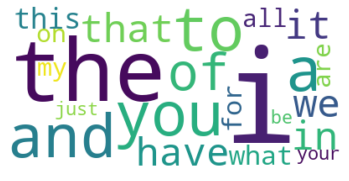

In [9]:
# Create string object for word cloud processing 
text = " ".join(word for word in Word_Frequency.Word)
noStop = ''  # Variable to prevent default stop word processing 

# Create word cloud 
wordcloud = WordCloud(stopwords=noStop, background_color="white").generate(text)

# Display word cloud using pyplot 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Display and save chart
plt.savefig("../Images/WordCloudAll.png")
plt.show()

In [10]:
Word_Frequency.set_index('Word', inplace=True)

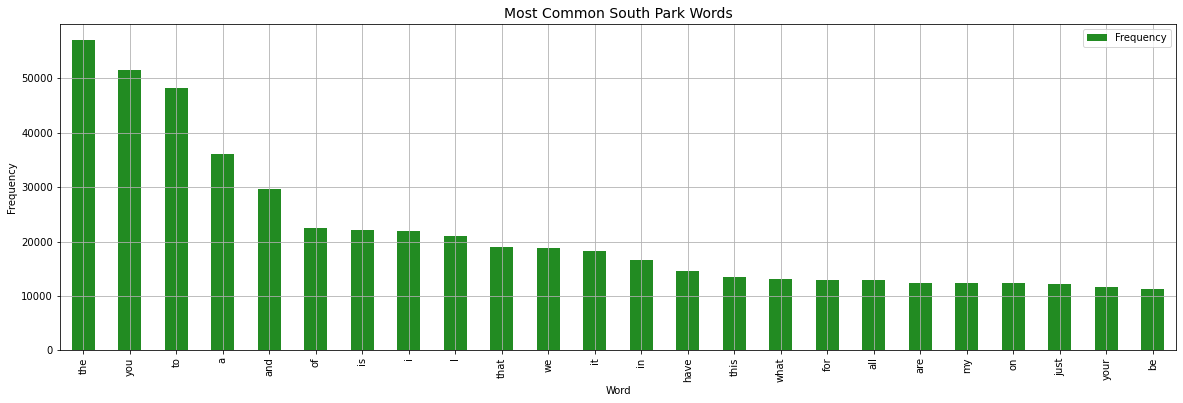

In [11]:
# Plot most common words
Word_Frequency.plot(xlabel="Word", ylabel="Frequency", kind="bar", figsize=(20,6), color='forestgreen')
plt.title(f"Most Common South Park Words", fontsize=14)
plt.grid()

# Display and save chart
plt.savefig("../Images/MostCommonAllBar.png")
plt.show()

### Process list with Stop Words Removed 
* Create a list of words and the number of times they occur 
* Select the most common 25 words using collections
* Build a data frame with the results 
* Display and save word cloud 
* Display and save bar chart 

In [12]:
# Count all the filtered words 
c = Counter(WordListFiltered)
wordlist= []
occurancelist = []

# Get most common words
most_common_words = c.most_common(25)

# Build lists to plot 
for x in range(len(most_common_words)-1):
    mcwlist = most_common_words[x]
    word = mcwlist[0]
    occurance = mcwlist[1]
    wordlist.append(word)
    occurancelist.append(occurance)
    
# Build DF
Word_Frequency = pd.DataFrame(columns = ['Word', 'Frequency'])
Word_Frequency['Word'] = wordlist
Word_Frequency['Frequency'] = occurancelist  

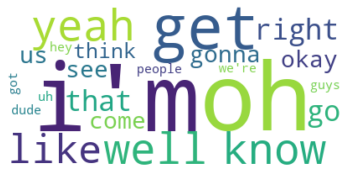

In [13]:
# Create string object for word cloud processing 
text = " ".join(word for word in Word_Frequency.Word)
noStop = '' # Variable to prevent default stop word processing

# Create word cloud 
wordcloud = WordCloud(stopwords=noStop, background_color="white").generate(text)

# Display word cloud using pyplot 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Display and save chart
plt.savefig("../Images/WordCloudFilt.png")
plt.show()

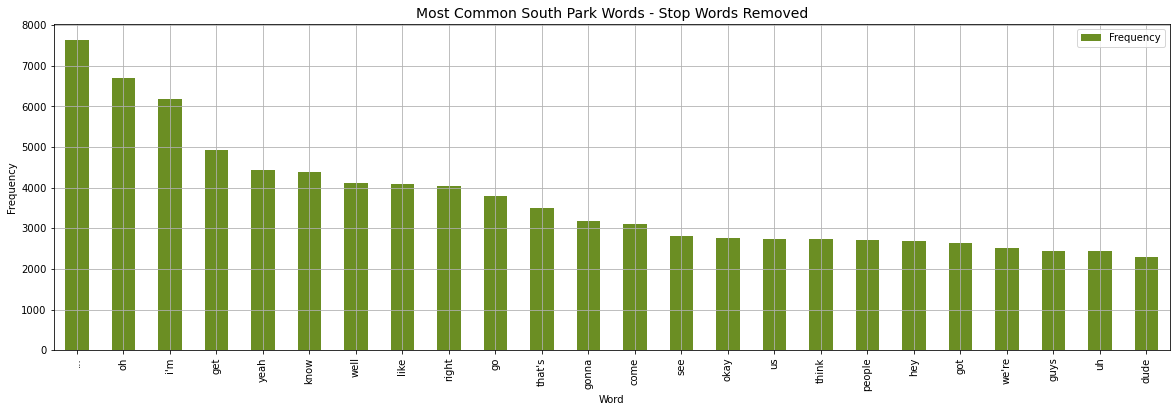

In [14]:
# Plot most common filtered words
Word_Frequency.set_index('Word', inplace=True)
Word_Frequency.plot(xlabel="Word", ylabel="Frequency", kind="bar", figsize=(20,6), color='olivedrab')
plt.title(f"Most Common South Park Words - Stop Words Removed", fontsize=14)
plt.grid()

# Display and save chart
plt.savefig("../Images/MostCommonFiltBar.png")
plt.show()

### Process list of Offensive words  
* Create a list of words and the number of times they occur 
* Select the most common 25 words using collections
* Build a data frame with the results 
* Display and save word cloud 
* Display and save bar chart 

In [15]:
# Count all the bad words 
c = Counter(WordListBad)
wordlist= []
occurancelist = []

# Get most common words
most_common_words = c.most_common(25)

# Build lists to plot 
for x in range(len(most_common_words)-1):
    mcwlist = most_common_words[x]
    word = mcwlist[0]
    occurance = mcwlist[1]
    wordlist.append(word)
    occurancelist.append(occurance)
    
# Build DF
Word_Frequency = pd.DataFrame(columns = ['Word', 'Frequency'])
Word_Frequency['Word'] = wordlist
Word_Frequency['Frequency'] = occurancelist

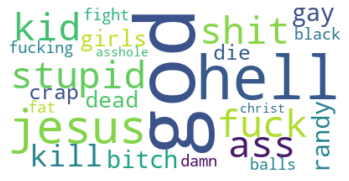

In [16]:
# Create string object for word cloud processing 
text = " ".join(word for word in Word_Frequency.Word)
noStop = ''# Variable to prevent default stop word processing

# Create word cloud 
wordcloud = WordCloud(stopwords=noStop, background_color="white").generate(text)

# Display word cloud using pyplot 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Display and save chart
plt.savefig("../Images/WordCloudBad.png")
plt.show()

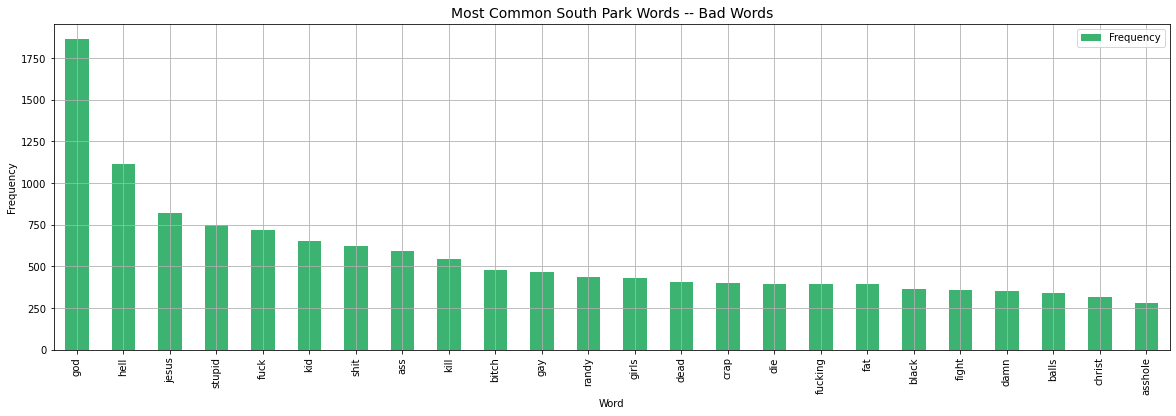

In [17]:
# Plot most common bad words 
Word_Frequency.set_index('Word', inplace=True)
Word_Frequency.plot(xlabel="Word", ylabel="Frequency", kind="bar", figsize=(20,6), color='mediumseagreen')
plt.title(f"Most Common South Park Words -- Bad Words", fontsize=14)
plt.grid()

# Display and save chart
plt.savefig("../Images/MostCommonBadBar.png")
plt.show()

### Note: the first word on the bad list - may not be a bad word depending on usage it would take a great deal of additional work to evaluate that word in context.  We may be able to compare it with sentiment scores (of course their reliability is also not a certainty.

In [18]:
BadWordDF.head()

,Season,Episode,Character,Bad Word
0,10,1,Kyle,fatass
1,10,1,Cartman,jew
2,10,1,Chef,randy
3,10,1,Clyde,sex
4,10,1,Chef,sexual


In [19]:
# Group Bad Words by Character and Sort by Frequency 
BadWordDFbyChar = pd.DataFrame(BadWordDF.groupby('Character')['Bad Word'].count()).reset_index()

# Grab the most frequent 25 
BadWordDFbyCharSort = pd.DataFrame(BadWordDFbyChar.sort_values(by='Bad Word' , ascending=False))
TopTenByChar = BadWordDFbyCharSort.head(25)

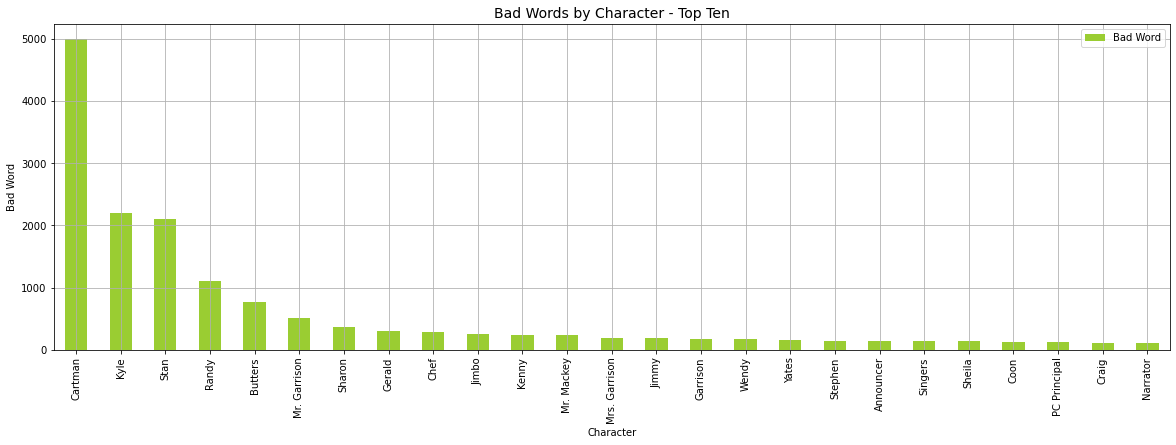

In [20]:
# Plot bad words by Character
TopTenByChar.set_index('Character', inplace=True)
TopTenByChar.plot(xlabel="Character", ylabel="Bad Word", kind="bar", figsize=(20,6), color='yellowgreen')
plt.title(f"Bad Words by Character - Top Ten", fontsize=14)
plt.grid()
plt.savefig("../Images/BadByCharacterBar.png")
plt.show()

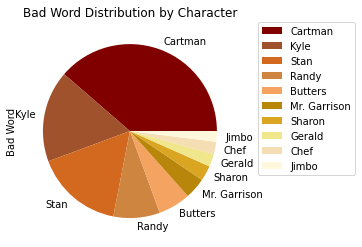

In [21]:
# Plot top ten offenders 
TopTenByCharPlot = TopTenByChar.head(10)
# Set some colors 
#colors = ['mediumturquoise', 'pink', 'deepskyblue', 'blue', 'lightcoral', 'goldenrod', 'darkorchid', 'wheat', 'mediumspringgreen', 'thistle']
colors = ['maroon', 'sienna', 'chocolate', 'peru', 'sandybrown', 'darkgoldenrod', 'goldenrod', 'khaki', 'wheat', 'cornsilk']
# Build plot 
TopTenByCharPlot.plot.pie(subplots=True, label='Sex', figsize=(20,4), colors=colors)

# Add Title and legend
plt.legend(bbox_to_anchor=(1.09,1), borderaxespad=0)
plt.title('Bad Word Distribution by Character')

# Display and save chart
plt.savefig("../Images/BadByCharacterPie.png")
plt.show()

In [35]:
# Group Bad Words by Season and Sort by Frequency 
BadWordDFbySeas = pd.DataFrame(BadWordDF.groupby('Season')['Bad Word'].count()).reset_index()
BadWordDFbySeasSort = pd.DataFrame(BadWordDFbySeas.sort_values(by='Bad Word' , ascending=False))

# Grab the most frequent 25 and sort by season number 
# TopTenBySeas = BadWordDFbySeasSort.head(25)
TopTenBySeas = BadWordDFbySeasSort
TopTenBySeas['Season'] = TopTenBySeas['Season'].astype(int)
TopTenBySeas = pd.DataFrame(TopTenBySeas.sort_values(by=('Season') , ascending=True))

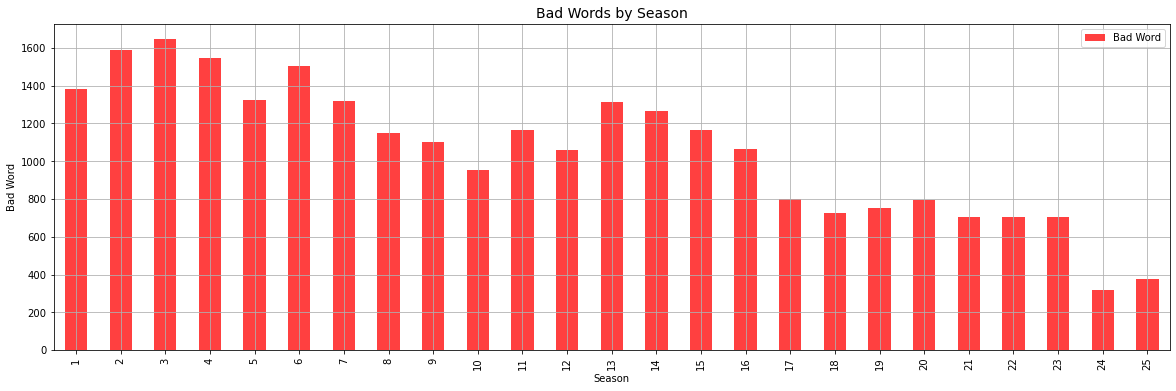

In [36]:
# Plot bad words by Season
TopTenBySeas.set_index('Season', inplace=True)
TopTenBySeas.plot(xlabel="Season", ylabel="Bad Word", kind="bar", figsize=(20,6), color='red', rot=90, alpha=0.75)
plt.title(f"Bad Words by Season", fontsize=14)
plt.xticks(rotation=90)
plt.grid()

# Display and save chart
plt.savefig("../Images/BadBySeasonBar.png")
plt.show()

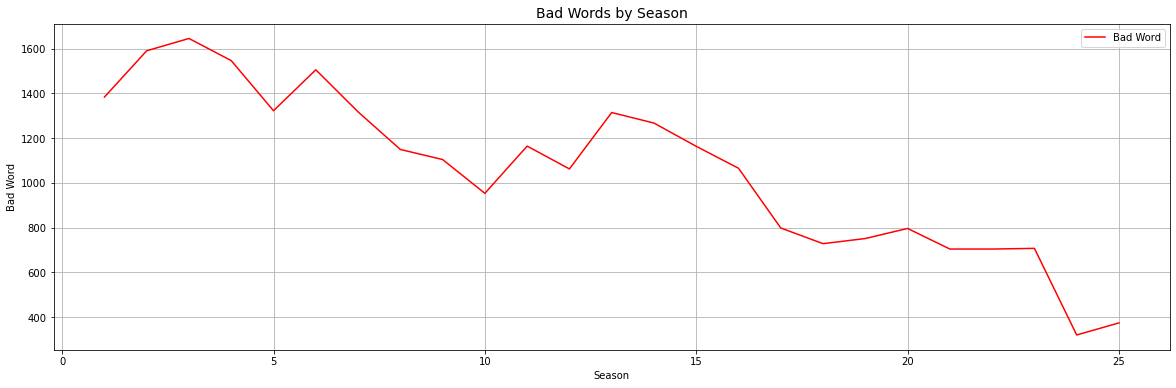

In [38]:
# Plot bad words by Season
TopTenBySeas.plot(xlabel="Season", ylabel="Bad Word", kind="line", figsize=(20,6), color='red')
plt.title(f"Bad Words by Season", fontsize=14)
plt.grid()

# Display and save chart
plt.savefig("../Images/BadBySeasonLine.png")
plt.show()

In [25]:
# Grab a clean copy of the data to avoid conflicts 
SP = SP_Diag.copy()

# Filter for positive sentiment  > 0
SPPosT = SP.loc[SP['Polarity'] >0 ]

# Filter for negative sentiment < 0
SPNegT = SP.loc[SP['Polarity'] <0 ]

# Group both datasets by Season and get the mean for polarity 
SPPos = SPPosT.groupby("Season")["Polarity"].mean().reset_index()
SPNeg = SPNegT.groupby("Season")["Polarity"].mean().reset_index()

# Sort both sets by season
SPPos = SPPos.sort_values(by=['Season']).reset_index(drop=True)
SPNeg = SPNeg.sort_values(by=['Season']).reset_index(drop=True)

### Positive Sentiment Over Seasons

The correlation between both factors is -0.66


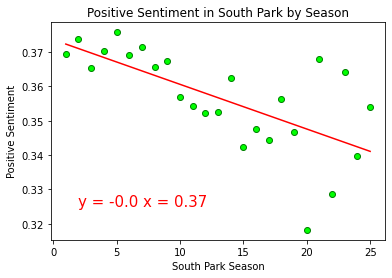

In [26]:
# Calculate the correlation coefficient and linear regression model 
# for season .vs  polarity 

# Define Figure
fig, ax = plt.subplots()

# Season .vs Polarity
Season = SPPos['Season']
Polarity = SPPos['Polarity']

# Get Correlation
correlation = st.pearsonr(Season, Polarity)
print(f"The correlation between both factors is {round(correlation[0],2)}")

# Show scatter plot
ax.scatter(Season, Polarity, marker="o", facecolors="lime", edgecolors="green")

# Set titles for scatter plot
ax.set_xlabel('South Park Season')
ax.set_ylabel('Positive Sentiment')
ax.set_title("Positive Sentiment in South Park by Season")

# using linregress from scipy.stats
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(Season, Polarity) # returns a tuple of values
regress_values = Season * slope + intercept

# making a text version of our equation for display
line_eq = "y = " + str(round(slope,2)) + " x = " + str(round(intercept,2))

# draw our regression line
ax.plot(Season,regress_values,"r-")

# annotate on our figure the line equation in red
ax.annotate(line_eq,(2,.325),fontsize=15,color="red")
plt.savefig("../Images/PositiveSentimentSeason.png")
plt.show()

### Negative Sentiment Over Seasons

The correlation between both factors is 0.4


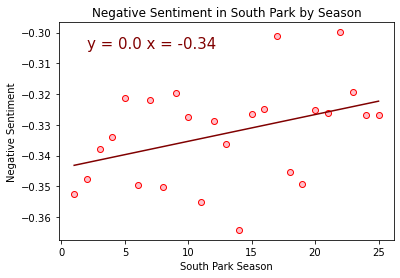

In [27]:
# Calculate the correlation coefficient and linear regression model 
# for season .vs  polarity 

# Define Figure
fig, ax = plt.subplots()

# Season .vs Polarity
Season = SPNeg['Season']
Polarity = SPNeg['Polarity']

# Get Correlation
correlation = st.pearsonr(Season, Polarity)
print(f"The correlation between both factors is {round(correlation[0],2)}")

# Show scatter plot
ax.scatter(Season, Polarity, marker="o", facecolors="pink", edgecolors="red")

# Set titles for scatter plot
ax.set_xlabel('South Park Season')
ax.set_ylabel('Negative Sentiment')
ax.set_title("Negative Sentiment in South Park by Season")

# using linregress from scipy.stats
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(Season, Polarity) # returns a tuple of values
regress_values = Season * slope + intercept

# making a text version of our equation for display
line_eq = "y = " + str(round(slope,2)) + " x = " + str(round(intercept,2))

# draw our regression line
ax.plot(Season,regress_values, color="maroon")

# annotate on our figure the line equation in red
ax.annotate(line_eq,(2,-.305),fontsize=15,color="maroon")
plt.savefig("../Images/NegativeSentimentSeason.png")
plt.show()

### Subjectivity Over Seasons

In [28]:
# Grab a clean copy of the data to avoid conflicts 
SP = SP_Diag.copy()

# Filter for rows with subjectivty value 
SPPosT = SP.loc[SP["Subjectivity"] >0]

# Group by Season and get the mean for subjectivity
SPPos = SPPosT.groupby("Season")["Subjectivity"].mean().reset_index()

# Sort by season
SPPos = SPPos.sort_values(by=['Season']).reset_index(drop=True)

The correlation between both factors is -0.37


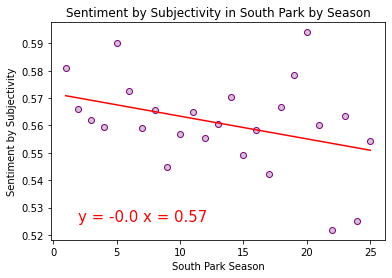

In [29]:
# Calculate the correlation coefficient and linear regression model 
# for season .vs  subjectivity

# Define Figure
fig, ax = plt.subplots()

# Season .vs Subjectivity
Season = SPPos['Season']
Polarity = SPPos['Subjectivity'] 

# Get Correlation
correlation = st.pearsonr(Season, Polarity)
print(f"The correlation between both factors is {round(correlation[0],2)}")

# Show scatter plot
ax.scatter(Season, Polarity, marker="o", facecolors="thistle", edgecolors="purple")

# Set titles for scatter plot
ax.set_xlabel('South Park Season')
ax.set_ylabel('Sentiment by Subjectivity')
ax.set_title('Sentiment by Subjectivity in South Park by Season')

# using linregress from scipy.stats
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(Season, Polarity) # returns a tuple of values
regress_values = Season * slope + intercept

# making a text version of our equation for display
line_eq = "y = " + str(round(slope,2)) + " x = " + str(round(intercept,2))

# draw our regression line
ax.plot(Season,regress_values,"r-")

# annotate on our figure the line equation in red
ax.annotate(line_eq,(2,.525),fontsize=15,color="red")
plt.savefig("../Images/SentimentSubjectivitySeason.png")
plt.show()